In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import numpy as np
from pathlib import Path
from torchsummary import summary

In [ ]:
PATH = Path("dataset") / "GTSRB" / "Training"
torch.set_float32_matmul_precision('high')
LABELS = ["20 km/h"
,"30 km/h"
,"50 km/h"
,"60 km/h"
,"70 km/h"
,"80 km/h"
,"End of speed limit"
,"100 km/h"
,"120 km/h"
,"No passing"
,"No passing for large vehicles"
,"Right of way"
,"Priority road"
,"Yield"
,"Stop"
,"No vehicles"
,"Large vehicles prohibited"
,"No entry"
,"General caution"
,"Dangerous curve to the left"
,"Dangerous curve to the right"
,"Double curve"
,"Bumpy road"
,"Slippery road"
,"Road narrows"
,"Road work"
,"Traffic signals"
,"Pedestrians"
,"Children crossing"
,"Bicycle crossing"
,"Ice warning"
,"Wild animals crossing"
,"End of all speed and passing limits"
,"Turn right ahead"
,"Turn left ahead"
,"Ahead only"
,"Go straight or right"
,"Go straight or left"
,"Keep right"
,"Keep left"
,"Roundabout mandatory"
,"End of no passing"
,"End of no passing by large vehicles"]

In [ ]:
_N = 32
batch_size = 256
n_classes = 43
epochs = 30
device = "cuda"#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def get_mean_std():
    transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    ])
    dataset = torchvision.datasets.ImageFolder(root=PATH,transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total = 0
    for images,_ in dataloader: # load a batch at a time
        n = images.size(0)
        total += 1
        mean  += images.mean(dim=[0,2,3])
        std   += images.std(dim=[0,2,3])
    std  /= total
    mean /= total
    return mean,std
# get_mean_std() # (tensor([0.3397, 0.3117, 0.3210]), tensor([0.2299, 0.2247, 0.2332]))

In [5]:
mean = torch.tensor([0.3397, 0.3117, 0.3210])
std = torch.tensor([0.2299, 0.2247, 0.2332])

def to_image(img): # convert to unormalized form for viewing
    _mean = mean.view(3,1,1)
    _std = std.view(3,1,1)
    return (img * _std + _mean).permute(1,2,0).numpy()

transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [6]:
dataset = torchvision.datasets.ImageFolder(root=PATH, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           num_workers=6,
                                           shuffle=True
                                           )
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          num_workers=6,
                                          shuffle=False
                                          )

Right of way


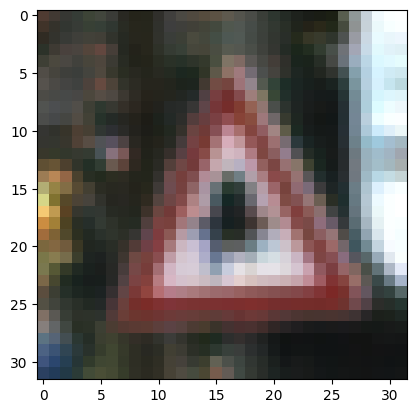

In [7]:
for img,label in train_loader:
    img = to_image(img[0])
    plt.imshow(img)
    print(LABELS[label[0]])
    break

In [9]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        x = torch.zeros((64,3,_N,_N))
        self.activation = torch.nn.functional.relu
        self.pool = torch.nn.MaxPool2d(2,2)

        self.conv1 = torch.nn.Conv2d(3,6,5)
        x = self.pool(self.activation(self.conv1(x)))
        
        self.conv2 = torch.nn.Conv2d(x.shape[1],16,5)
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        self.dense1 = torch.nn.Linear(x.shape[1],128)
        x = self.activation(self.dense1(x))
        self.dense2 = torch.nn.Linear(x.shape[1],64)
        x = self.activation(self.dense2(x))
        self.final = torch.nn.Linear(x.shape[1],n_classes)


    def forward(self,x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        
        x = torch.flatten(x, start_dim=1)

        x = self.activation(self.dense1(x))
        x = self.activation(self.dense2(x))
        x = self.final(x)

        return x
        
model = torch.compile(Model()).to(device)
summary(model,(3,32,32),batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [512, 6, 28, 28]             456
         MaxPool2d-2           [512, 6, 14, 14]               0
            Conv2d-3          [512, 16, 10, 10]           2,416
         MaxPool2d-4            [512, 16, 5, 5]               0
            Linear-5                 [512, 128]          51,328
            Linear-6                  [512, 64]           8,256
            Linear-7                  [512, 43]           2,795
             Model-8                  [512, 43]               0
Total params: 65,251
Trainable params: 65,251
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 6.00
Forward/backward pass size (MB): 31.87
Params size (MB): 0.25
Estimated Total Size (MB): 38.12
----------------------------------------------------------------


In [10]:
loss = torch.nn.CrossEntropyLoss().to(device)
optimiser = torch.optim.Adam(model.parameters())#torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

In [ ]:

def train(model,loss_func,optimiser):
    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            images = data[0].to(device)
            labels = data[1].to(device)

            optimiser.zero_grad()
            preds = model(images)
            loss = loss_func(preds, labels)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss {total_loss / len(train_loader):.3f}")

In [14]:
train(model,loss,optimiser)

/home/rob/code/Project/pytorchenv/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:124: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Epoch 0: Loss 3.148
Epoch 1: Loss 1.559
Epoch 2: Loss 0.785
Epoch 3: Loss 0.517
Epoch 4: Loss 0.393
Epoch 5: Loss 0.313
Epoch 6: Loss 0.264
Epoch 7: Loss 0.215
Epoch 8: Loss 0.185
Epoch 9: Loss 0.156
Epoch 10: Loss 0.132
Epoch 11: Loss 0.116
Epoch 12: Loss 0.104
Epoch 13: Loss 0.093
Epoch 14: Loss 0.078
Epoch 15: Loss 0.071
Epoch 16: Loss 0.064
Epoch 17: Loss 0.055
Epoch 18: Loss 0.050
Epoch 19: Loss 0.042
Epoch 20: Loss 0.042
Epoch 21: Loss 0.041
Epoch 22: Loss 0.035
Epoch 23: Loss 0.028
Epoch 24: Loss 0.025
Epoch 25: Loss 0.020
Epoch 26: Loss 0.020
Epoch 27: Loss 0.020
Epoch 28: Loss 0.016
Epoch 29: Loss 0.019
